# W266 Team 4_1 - Phase 1 Submission

## Team

- Maegan Kornexl: mkornexl@berkeley.edu
- I-Hsiu Kao: ihsiukao@berkeley.edu
- Nathan Arias: nathanarias@berkeley.edu
- Thomas Dolan: tdolan@berkeley.edu

## Phase Leader Plan 

| Phase   | Leader |
|--------|-------|
| Phase I - Project Plan: Describe Datasets, Tasks, and Metrics      | Thomas Dolan    |
| Phase II EDA, Baseline Pipeline On All Data    | Nathan Arias     |
| Phase III - Advanced Model Architectures and Loss Functions | I-Hsiu Kao    |
| Phase IV - Final Project | Maegan Kornexl    |


## Credit Assignment 

| Responsibility   | Assignee | Expected Time Commitment (Hrs)| 
|--------|-------|-------|
| Complete abstract | Nathan Arias         | 1|
| Compute distributions, missing data and summary statistics                                    | Thomas Dolan, Nathan Arias  |  1,2|
| Literature review - regression, random forest, SVM, GCN                                              | Maeghan Kornexl| 3|
| Map out pipelines for cleaning, preprocessing, modeling, schematize                                              | Thomas Dolan, I-Hsiu Kao| 2, 2 |
| Establish timeline for deliverables - Gantt Chart                     | I-Hsiu Kao    |  1|
|Blob Storage and Team Permissions| Thomas Dolan | 2|

## Abstract

This study aims to enhance customer satisfaction and operational efficiency in the airline industry by developing a predictive model to forecast flight departure delays. The focus is on predicting delays exceeding 15 minutes at least two hours before the scheduled departure, utilizing a dataset comprising US domestic flight details and corresponding weather conditions from 2015 to 2021. By applying machine learning techniques to analyze historical data, this research identifies key predictors of flight delays, thereby enabling stakeholders to make informed decisions. The proposed model's performance is rigorously evaluated using a comprehensive set of metrics, including accuracy, precision, recall, Fβ Score, Mean Absolute Error (MAE) in delay minutes, and Flight Delay Rate. These evaluations aim to ascertain the model's effectiveness in reducing the financial and social impacts of flight delays, thereby contributing to improved customer satisfaction and operational efficiency in the airline sector.

## Data Description

#####Flights Data:
This dataset includes on-time performance data for passenger flights, sourced from the U.S. Department of Transportation. It covers flight details from 2015 to 2021, with 109 columns for millions of flights. The data is available in subsets for 1 quarter, 2 quarters, and 1 year, which we will be using for different phases of the project.

#####Weather Data:
As weather is known to impact flight schedules, this dataset contains weather conditions from the National Oceanic and Atmospheric Administration. It includes 177 features from 2015 to 2021. We will use this dataset along with the Flights Data to generate weather patterns at both departure and arrival points. This pattern is crucial for understanding the environmental factors affecting flight schedule.

#####Airport Data:
This dataset provides metadata about U.S. airports. It includes key details about each airport, facilitating a deeper understanding of how specific airports' characteristics might influence flight delays.

#####Airport Codes:
This table helps conversions between IATA and ICAO airport codes. This cross-referencing is essential for integrating different datasets, ensuring cohesive and comprehensive analysis.

#####OTPW:
This dataset features a pre-joined dataset combining flight on-time performance with local weather data, creating a robust foundation for predictive modeling. This merged dataset is available for various periods, enhancing the analytical depth available for identifying delay determinants.

### Data Sources

Datasets: 

1) Bureau of Labor Statistics - Carrier On-Time Performance (Flights Data) - [Link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ)
2) NCEI Quality Controlled Local Climatological Data (QCLCD) Publication - [Link](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00679)
3) Datahub - (Airport Codes) - [Link](https://datahub.io/core/airport-codes)
  

### Column Breakdown

#### Missing Value Analysis 

##### `Flight Dataset`
A preliminary sampling of 3 month period within the fights dataset revealed that of the original 109 columns 53 columns contain null identity exceeding 79%. The remaining 56 columns of data contain less than 4% null identity

| Descriptor   | Column Count |
|--------|-------|
|Original Column Count| 109|
|Columns with Null Identity > 79%| 53|
|Columns with Null Identity < 4%| 56|




##### `Weather Dataset`

A sampling of the same 3 month period within the weather dataset revealed that of the 127 original columns, 113 columns contain null identity exceeding 26%. The remaining 14 columns of data contain less that 7% null identity.


| Descriptor   | Column Count |
|--------|-------|
|Original Column Count| 127|
|Columns with Null Identity > 26%| 113|
|Columns with Null Identity < 7%| 14|





In [0]:
import numpy as np
import seaborn as sns
import pandas as pd 
import plotly.express as px 
from pyspark.sql.functions import *

data_BASE_DIR = "dbfs:/mnt/mids-w261/"
df_flights = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/")
df_weather = spark.read.parquet(f"dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/")


#counting null values in each column for flight and weather spark dataframes 
flight_null_dataframe =  df_flights.select([count(when(col(c).isNull(),c)).alias(c) for c in df_flights.columns])
weather_null_dataframe =  df_weather.select([count(when(col(c).isNull(),c)).alias(c) for c in df_weather.columns])

#row count in each dataframe
row_count_flights = df_flights.count()
row_count_weather = df_weather.count()

#to pandas for analysis and viz
flight_null_count_pandas = flight_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})
weather_null_count_pandas = weather_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})

#create percent_null column 
flight_null_count_pandas['percentNull'] = np.round(flight_null_count_pandas['nullCount'] * 100 / row_count_flights , 2)
weather_null_count_pandas['percentNull'] = np.round(weather_null_count_pandas['nullCount'] * 100 / row_count_weather , 2)

#column names with acceptable percent null values 
nonnull_cols_flights = flight_null_count_pandas[flight_null_count_pandas['percentNull'] < 4]['index'].to_list()
nonnull_cols_weather = weather_null_count_pandas[weather_null_count_pandas['percentNull'] < 7]['index'].to_list()

#null count percent by column in 3month flight dataset
flight_null_fig = px.scatter(flight_null_count_pandas, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - Flights',
                              color = 'percentNull', color_continuous_scale='bluered')
flight_null_fig.update_layout(title_x = 0.5, height = 400, xaxis={'categoryorder':'total ascending'})
flight_null_fig.update_xaxes(title = 'Column Name', visible = False)
flight_null_fig.update_yaxes(title = 'Percent Null')


#null count percent by column in 3month weather dataset
weather_null_fig = px.scatter(weather_null_count_pandas, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - Weather',
                              color = 'percentNull', color_continuous_scale='bluered')
weather_null_fig.update_layout(title_x = 0.5, height = 400, xaxis={'categoryorder':'total ascending'})
weather_null_fig.update_xaxes(title = 'Column Name', visible = False)
weather_null_fig.update_yaxes(title = 'Percent Null')


display(flight_null_fig,weather_null_fig)

In [0]:
df_otpw = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")

otpw_null_dataframe =  df_otpw.select([count(when(col(c).isNull(),c)).alias(c) for c in df_otpw.columns])
row_count_otpw = df_otpw.count()
otpw_null_count_pandas = otpw_null_dataframe.toPandas().transpose().reset_index().rename(columns = {0:'nullCount'})
otpw_null_count_pandas['percentNull'] = np.round(otpw_null_count_pandas['nullCount'] * 100 / row_count_otpw , 2)


nonnull_cols_otpw = otpw_null_count_pandas[otpw_null_count_pandas['percentNull'] < 4]['index'].to_list()
otpw_null_fig = px.scatter(otpw_null_count_pandas, x = 'index', y= 'percentNull', title = 'Null Percentage by Column - OTPW', color = 'percentNull', color_continuous_scale='bluered')
otpw_null_fig.update_layout(title_x = 0.5, height = 400, xaxis={'categoryorder':'total ascending'})
otpw_null_fig.update_xaxes(title = 'Column Name', visible = False)
otpw_null_fig.update_yaxes(title = 'Percent Null')
display(otpw_null_fig)

### Distribution of Continuous Variables

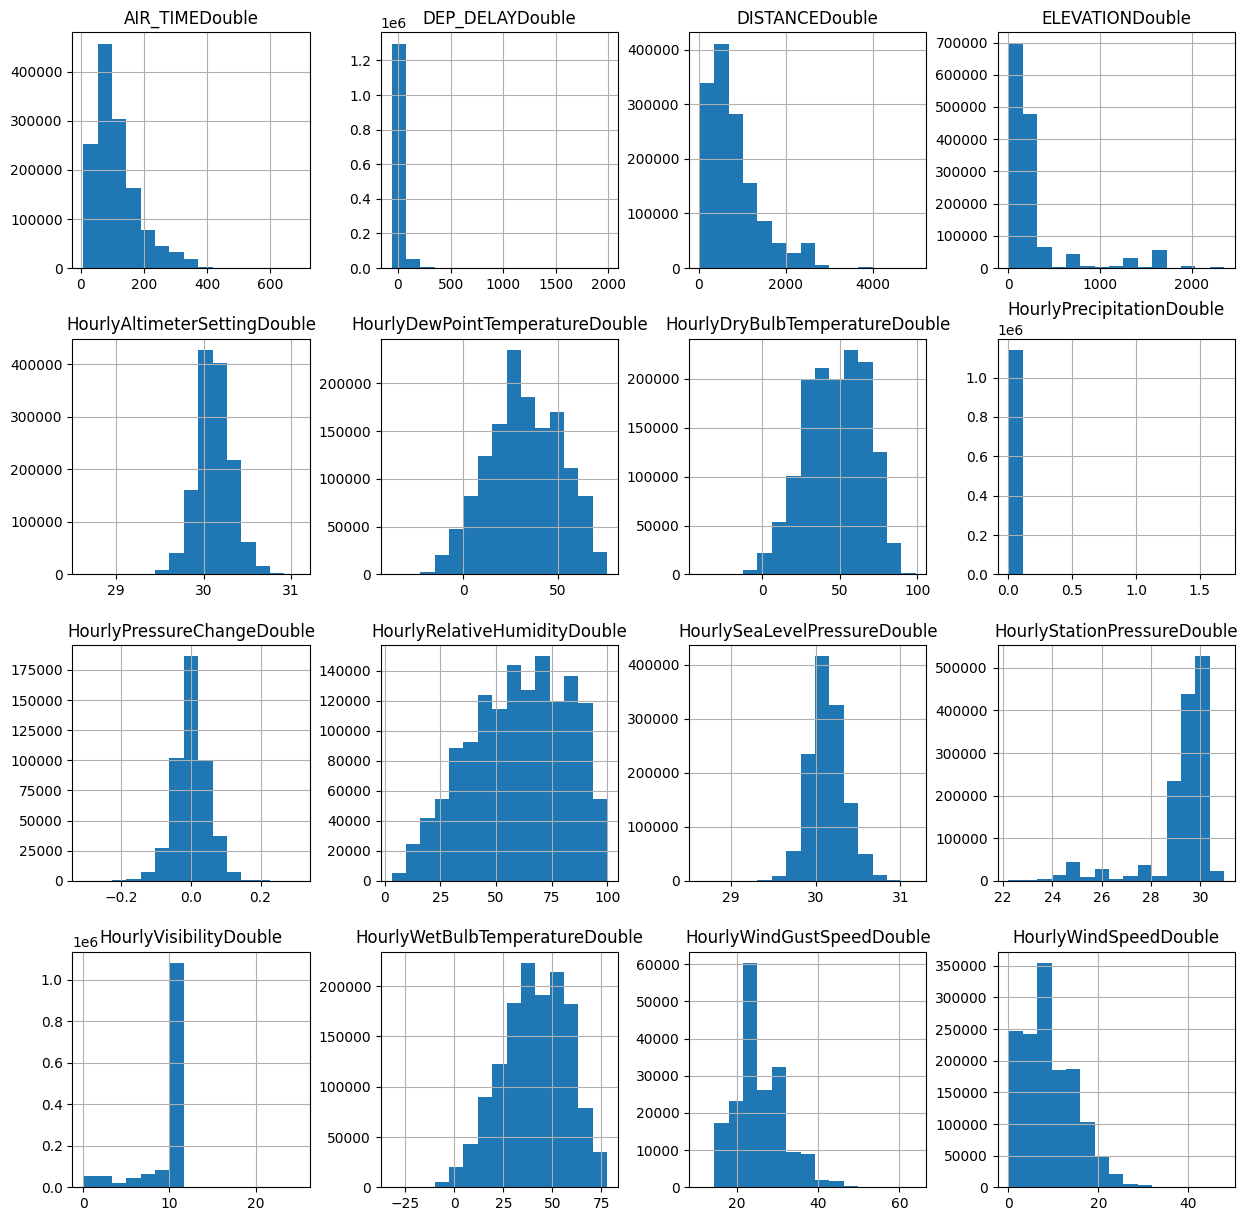

In [0]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import numpy as np
import seaborn as sns

# OTPW
df_otpw = spark.read.format("csv").option("header","true").load(f"dbfs:/mnt/mids-w261/OTPW_3M_2015.csv")

con_cols = ["AIR_TIME","DEP_DELAY","DISTANCE", "ELEVATION", "HourlyAltimeterSetting","HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyPrecipitation", "HourlyPressureChange", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyStationPressure", "HourlyVisibility", "HourlyWetBulbTemperature", "HourlyWindGustSpeed", "HourlyWindSpeed"]

otpw_cols = ["AIR_TIMEDouble", "DEP_DELAYDouble", "DISTANCEDouble", "ELEVATIONDouble", "HourlyAltimeterSettingDouble", "HourlyDewPointTemperatureDouble", "HourlyDryBulbTemperatureDouble", "HourlyPrecipitationDouble", "HourlyPressureChangeDouble", "HourlyRelativeHumidityDouble", "HourlySeaLevelPressureDouble", "HourlyStationPressureDouble", "HourlyVisibilityDouble", "HourlyWetBulbTemperatureDouble", "HourlyWindGustSpeedDouble", "HourlyWindSpeedDouble"]

df_otpw = df_otpw.withColumn("AIR_TIMEDouble", F.col("AIR_TIME").cast("double"))
df_otpw = df_otpw.withColumn("DISTANCEDouble", F.col("DISTANCE").cast("double"))
df_otpw = df_otpw.withColumn("ELEVATIONDouble", F.col("ELEVATION").cast("double"))
df_otpw = df_otpw.withColumn("HourlyAltimeterSettingDouble", F.col("HourlyAltimeterSetting").cast("double"))
df_otpw = df_otpw.withColumn("HourlyDewPointTemperatureDouble", F.col("HourlyDewPointTemperature").cast("double"))
df_otpw = df_otpw.withColumn("HourlyDryBulbTemperatureDouble", F.col("HourlyDryBulbTemperature").cast("double"))
df_otpw = df_otpw.withColumn("HourlyPrecipitationDouble", F.col("HourlyPrecipitation").cast("double"))
df_otpw = df_otpw.withColumn("HourlyPressureChangeDouble", F.col("HourlyPressureChange").cast("double"))
df_otpw = df_otpw.withColumn("HourlyRelativeHumidityDouble", F.col("HourlyRelativeHumidity").cast("double"))
df_otpw = df_otpw.withColumn("HourlySeaLevelPressureDouble", F.col("HourlySeaLevelPressure").cast("double"))
df_otpw = df_otpw.withColumn("HourlyStationPressureDouble", F.col("HourlyStationPressure").cast("double"))
df_otpw = df_otpw.withColumn("HourlyVisibilityDouble", F.col("HourlyVisibility").cast("double"))
df_otpw = df_otpw.withColumn("HourlyWetBulbTemperatureDouble", F.col("HourlyWetBulbTemperature").cast("double"))
df_otpw = df_otpw.withColumn("HourlyWindGustSpeedDouble", F.col("HourlyWindGustSpeed").cast("double"))
df_otpw = df_otpw.withColumn("HourlyWindSpeedDouble", F.col("HourlyWindSpeed").cast("double"))
df_otpw = df_otpw.withColumn("DEP_DELAYDouble", F.col("DEP_DELAY").cast("double")) #Possible Target Variable

otpw_data = df_otpw.select(*otpw_cols).toPandas()

otpw_data.hist(figsize=(15,15), bins=15)
plt.show()

## Machine Algorithms and Metrics
###Algorithms:
#####Linear Regression (Baseline):
Linear Regression models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to observed data. The equation of a simple linear regression line is \\(y = mx +b \\), where \\(y\\) is the outcome, \\(x\\) is the feature, \\(m\\) is the weight of the feature, and \\(b\\) is the intercept. There can be multiple features in a single linear regression model. We will use Scikit-learn's LinearRegression API to implement the linear regression model. We will use Mean Squared Error (MSE) as our loss function. MSE measures the average squared difference between the estimated values and the actual value. \\(MSE = \frac{1}{n}\sum_{i=1}^{D}(\hat{y}_i-y_i)^2\\), \\(y_i\\) is the actual value and \\(\hat{y}_i\\) is the predicted value

Relavant Literature: Lu Hao, Mark Hansen, Yu Zhang, Joseph Post,New York, New York: Two ways of estimating the delay impact of New York airports,
Transportation Research Part E: Logistics and Transportation Review; https://doi.org/10.1016/j.tre.2014.07.004


#####Random Forest:
Random Forest is an ensemble learning method that combines multiple decision trees to improve prediction accuracy and control overfitting. It's effective for handling large datasets with large feature sets. We will use scikit-learn's RandomForestRegressor to predict flight delays. We will use Mean Squared Error (MSE) as our loss function. MSE measures the average squared difference between the estimated values and the actual value. \\(MSE = \frac{1}{n}\sum_{i=1}^{D}(\hat{y}_i-y_i)^2\\), \\(y_i\\) is the actual value and \\(\hat{y}_i\\) is the predicted value

Relavent Literature: Jun Chen and Meng Li. "Chained Predictions of Flight Delay Using Machine Learning," AIAA 2019-1661. AIAA Scitech 2019 Forum. January 2019.; https://doi.org/10.2514/6.2019-1661

###Standard Metrics:
#####Accuracy:
Accuracy measures the proportion of correct predictions among the total predictions made, encompassing both delays and non-delays.

######\\(Accuracy = \frac{True Positives + True Negatives} {Total Predictions}\\)

#####Precision:
Precision is the proportion of true positive predictions in all positive predictions. It is crucial for minimizing false positives, ensuring that when the model predicts a delay, it's likely to be correct.

######\\(Precision = \frac{True Positives}{True Positives + False Positives}\\)

#####Recall:
Recall measures the proportion of actual positive cases that were correctly identified. High recall is essential to ensure that the model captures most of the actual delays.

###### \\(Recall = \frac{True Positives}{True Positives + False Negatives}\\)

#####F1-Score:
The F1-score provides a single metric that combines recall and precision to assess their balance, considering their trade-off. It is particularly useful when you want to find a balance between precision and recall.

######\\(F1 = 2 * \frac{Precision × Recall}{Precision + Recall}\\)

#####Fβ-Score:
The F-beta score is a more flexible metric that allows you to adjust the balance between precision and recall. It does this by introducing a beta parameter, which assigns more weight to recall or precision depending on the scalar value beta takes.

######\\(F\beta = (1 + \beta^2) * \frac{Precision \times Recall}{(\beta^2 \cdot Precision) + Recall}\\)






###Domain-Specific Metrics:
#####Mean Absolute Error (MAE) in Delay Minutes:
MAE is the average absolute difference between the predicted delay time and the actual delay time in minutes. It gives a direct understanding of the prediction error in the time domain.
  
\\(MAE = \frac{1}{n} * \sum_{i=1}^{n} y_i − \hat{y}_i\\), where \\(y_i\\) is the actual delay time and \\(\hat{y}_i\\) is the predicted delay time in minutes

#####Flight Delay Rate:
The percentage of flights predicted to be delayed that were delayed. Flight Delay Rate helps evaluate the model's performance.

######\\(\textit{Flight Delay Rate} = \frac {\textit{Number of Flights Predicted to be Delayed}} {\textit{Number of Correctly Predicted Delayed Flights}}\\)


## Project Timeline


In [0]:
timelineBlock = pd.DataFrame([
    dict(Task="Set up shared folders and databucket on Databricks", Start='2024-03-11', Finish='2024-03-14'),
    dict(Task="Familiarize with datasets", Start='2024-03-11', Finish='2024-03-17'),
    dict(Task="Complete Phase 1 document of the Project", Start='2024-03-11', Finish='2024-03-17'),
    dict(Task="Perform EDA", Start='2024-03-14', Finish='2024-03-24'),
    dict(Task="Select features to be used from datasets", Start='2024-03-14', Finish='2024-03-24'),
    dict(Task="Implement baseline models and evaluate", Start='2024-03-22', Finish='2024-03-31'),
    dict(Task="Fine-tune baseline models", Start='2024-03-31', Finish='2024-04-03'),
    dict(Task="Complete Phase 2 document of the Project", Start='2024-03-31', Finish='2024-04-07'),
    dict(Task="Implement machine learning algorithms", Start='2024-04-08', Finish='2024-04-12'),
    dict(Task="Evaluate performance of each algorithms", Start='2024-04-08', Finish='2024-04-12'),
    dict(Task="Conduct hyperparameter tuning", Start='2024-04-12', Finish='2024-04-16'),
    dict(Task="Clean up code", Start='2024-04-12', Finish='2024-04-18'),
    dict(Task="Conduct testing on 2019 dataset", Start='2024-04-14', Finish='2024-04-18'),
    dict(Task="Complete Phase 3 document of the Project", Start='2024-04-15', Finish='2024-04-20')
])

fig = px.timeline(timelineBlock, x_start="Start", x_end="Finish", y="Task")
fig.update_yaxes(autorange="reversed")
fig.show()

## Machine Learning Pipelines

#####1. Storage Bucket Setup
- Ensure that Flights Data, Weather Data, Airport Data, and Airport Codes can be loaded into notebook.
#####2. Data Cleaning and Preprocessing
- Preliminary check on missing values.
- Convert categorical data (ex: one-hot encoding).
- Normalize or continuous features if necessary.
- Split the data into train, validation, and test sets.
#####3. Exploratory Data Analysis (EDA)
- Visualize the distribution of variables.
- Identify outliers.
- Understand correlations between variables and outcomes
- Summarize each variable.
#####4. Feature Engineering
- Select features for predicting delays using techniques like Principal Component Analysis (PCA) or Lasso Regression.
#####5. Model Building
- Select a suitable machine learning algorithm.
- Train models on the training dataset.
- Adjusting parameters along the way.
- Save trained models.
#####6. Model Evaluation
- Predict outcomes on the test dataset.
- Calculate performance metrics.
- Compare results and select models.
#####7. Hyperparameter Tuning and Optimization
- Use grid or random search to explore different hyperparameter configurations.
- Train selected models using different hyperparameters.
- Evaluate selected models using the test data.
#####8. Evaluate Model on 2019 Dataset
- Use 2019 data as a blind test set that is never consulted during training.
- Report  evaluation metrics in terms of cross-fold validation over the training set (2015-2018)
- Report evaluation metrics in terms of the 2019 dataset
- Report cluster size and experiment times for training and blind set evaluation